# Plant Leaf Disease Classifier
### PlantVillage Dataset -> https://www.tensorflow.org/datasets/catalog/plant_village

"The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease."

This program uses a classifier where the feature extractor is the InceptionV3 with a trainable classifier head

In [1]:
# Imports

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Load training data
ds_train, ds_info = tfds.load('plant_village', split = 'train', with_info = True) 

train_split, val_split, test_split = 'train[:70%]', 'train[70%:85%]', 'train[85%:]'
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples, seed=42)

ds_train = tfds.load('plant_village', split = train_split, as_supervised=True)
ds_val = tfds.load('plant_village', split = val_split, as_supervised=True)
ds_test = tfds.load('plant_village', split = test_split, as_supervised=True)
class_names = ds_info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incomplete193FHF/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [3]:
print(f"Number of examples in training set: {len(list(ds_train))}")
print(f"Number of examples in validation set: {len(list(ds_val))}")
print(f"Number of examples in test set: {len(list(ds_test))}")

Number of examples in training set: 38012
Number of examples in validation set: 8146
Number of examples in test set: 8145


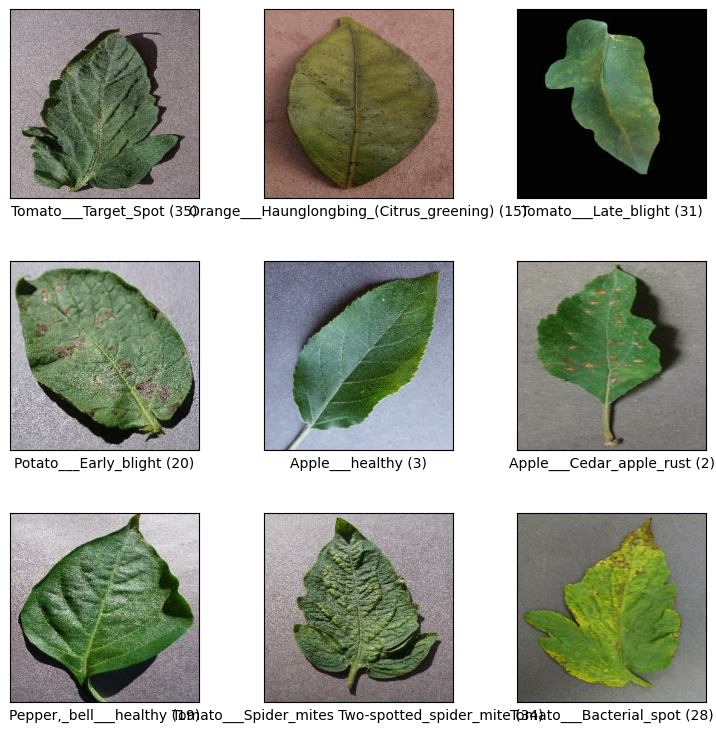

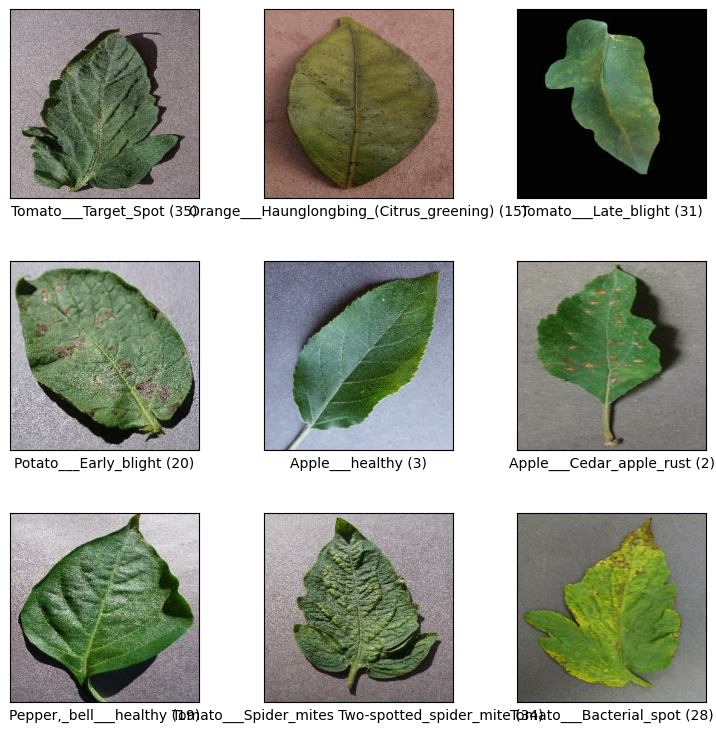

In [4]:
# Load the dataset for visualization
ds_train_visualize = tfds.load('plant_village', split=train_split, as_supervised=True)

# Display examples using the original dataset
tfds.show_examples(ds_train_visualize, ds_info)

In [5]:
# Define function for augmenting the training images
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  
  return image, label



In [6]:
# Apply the augs to the training set 

ds_train = ds_train.map(augment)

In [7]:
# Resize and normalise the dataset

def preprocess(image, label):
  image = tf.image.resize(image, (224, 224))
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

In [8]:
# Apply preprocessing to train, test and val

ds_train = ds_train.map(preprocess)
ds_val = ds_val.map(preprocess)
ds_test = ds_test.map(preprocess)

In [9]:
# Batch and prefetch the datasets
batch_size = 32
ds_train = ds_train.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 5.4 MB/s eta 0:00:00


In [11]:
from keras_tuner import HyperModel
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [12]:
class PlantDiseaseHyperModel(HyperModel):
  def __init__(self, input_shape, num_classes):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def build(self, hp):
    # Load the base feature extractor
    inception = InceptionV3(include_top = False,
                            weights = 'imagenet',
                            input_shape = (224,224, 3))

    # Freeze the early feature layers
    for layer in inception.layers:
      layer.trainable = False

    # Choose last pre-trained layer
    inception_last_layer = inception.get_layer('mixed7')
    print(('The output shape of last layer is: ', inception_last_layer.output_shape))
    inception_last_output = inception_last_layer.output

    # Add the classification head
    x = tf.keras.layers.GlobalAveragePooling2D()(inception_last_output)
    x = tf.keras.layers.Dense(units = hp.Int('units', min_value = 512, max_value = 1024, step=32),
                              activation = 'relu')(x)
    x = tf.keras.layers.Dense(units = hp.Int('units', min_value = 32, max_value = 512, step=32),
                              activation = 'relu')(x)
    output = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')(x)

    # Create the final model
    model = Model(inputs=inception.input, outputs = output)

    # Compile the model
    model.compile(optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value = 1e-4,
                                                                 max_value = 1e-2, sampling = 'LOG')),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy']
                  )
    return model

In [13]:
from keras_tuner.tuners import RandomSearch

input_shape = (224, 224, 3)
num_classes = (len(ds_info.features['label'].names))

In [14]:
hypermodel = PlantDiseaseHyperModel(input_shape, num_classes)

In [15]:
tuner = RandomSearch(
    hypermodel,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 1,
    directory = 'my_dir',
    project_name = 'Plant_Disease'
    )

87910968/87910968 [==============================] - 0s 0us/step
('The output shape of last layer is: ', (None, 12, 12, 768))


In [18]:
# Define callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

#search for the best hyperparameters
tuner.search(ds_train, epochs = 5, validation_data = ds_val, callbacks = [stop_early])

# Get the best HP's
best_hps = tuner.get_best_hyperparameters(num_trials = 5)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the densely connected layer is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 09m 57s]
val_accuracy: 0.9555609822273254

Best val_accuracy So Far: 0.9562975764274597
Total elapsed time: 00h 51m 49s

The hyperparameter search is complete. The optimal number of units in the densely connected layer is 832 and the optimal learning rate for the optimizer is 0.00014791121556251174.



In [19]:
# Buid the model with the best dense units
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [stop_early])

('The output shape of last layer is: ', (None, 12, 12, 768))
Epoch 1/10
1188/1188 [==============================] - 116s 93ms/step - loss: 1.0244 - accuracy: 0.7433 - val_loss: 0.3656 - val_accuracy: 0.8959
Epoch 2/10
1188/1188 [==============================] - 102s 86ms/step - loss: 0.2899 - accuracy: 0.9157 - val_loss: 0.2342 - val_accuracy: 0.9263
Epoch 3/10
1188/1188 [==============================] - 109s 92ms/step - loss: 0.2057 - accuracy: 0.9365 - val_loss: 0.1873 - val_accuracy: 0.9390
Epoch 4/10
1188/1188 [==============================] - 102s 86ms/step - loss: 0.1646 - accuracy: 0.9479 - val_loss: 0.1598 - val_accuracy: 0.9457
Epoch 5/10
1188/1188 [==============================] - 102s 86ms/step - loss: 0.1391 - accuracy: 0.9561 - val_loss: 0.1415 - val_accuracy: 0.9554
Epoch 6/10
1188/1188 [==============================] - 109s 91ms/step - loss: 0.1230 - accuracy: 0.9600 - val_loss: 0.1320 - val_accuracy: 0.9547
Epoch 7/10
1188/1188 [==============================] - 1

In [20]:
# Evaluate model on testset
loss, accuracy = model.evaluate(ds_test)
print(f"Test loss: {loss}")
print(f"Test Accuracy: {accuracy}")

255/255 [==============================] - 15s 60ms/step - loss: 0.1073 - accuracy: 0.9646
Test loss: 0.10729246586561203
Test Accuracy: 0.9646408557891846


In [ ]:
# def feature_extractor():

#   # instantiate the model
#   inception = InceptionV3(include_top = False,
#                           weights = 'imagenet',
#                           input_shape = (224,224, 3))

#   # Freeze the early feature layers

#   for layer in inception.layers:
#     layer.trainable = False

#   # # Choose last pre-trained layer
#   # inception_last_layer = feature_extractor.get_layer(last_layer)
#   # print(('The output shape of last layer is: ', inception_last_layer.output_shape))
#   # inception_last_output = inception_last_layer.output

#   return inception

# #inception.summary()

In [ ]:
  # # Choose last pre-trained layer
  # inception_last_layer = feature_extractor().get_layer('mixed7')
  # print(('The output shape of last layer is: ', inception_last_layer.output_shape))
  # inception_last_output = inception_last_layer.output


In [ ]:
# def classifier(last_output):
#   # Add classification layers to the head of the Model
#   x = tf.keras.layers.Flatten()(last_output)
#   x = tf.keras.layers.Dense(512, activation = 'relu')(x)
#   x = tf.keras.layers.Dense(256, activation = 'relu')(x)
#   x = tf.keras.layers.Dense(38, activation = 'softmax', name = 'classification')(x)

#   return x

In [ ]:
# def final_model():
#   inception_last_layer = feature_extractor().get_layer('mixed7')
#   print(('The output shape of last layer is: ', inception_last_layer.output_shape))

#   inception_last_output = inception_last_layer.output
#   classification_output = classifier(inception_last_output)

#   return classification_output

In [ ]:
# model.summary()

In [ ]:
print("Test loss : ", loss)
print("Test accuracy : ", accuracy)

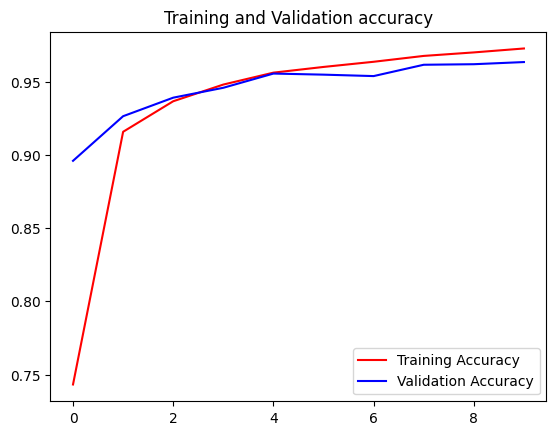

<Figure size 640x480 with 0 Axes>

In [21]:

# Plot training and val curves

acc = history.history['accuracy']
val_acc = history.history ['val_accuracy']
loss = history.history ['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()

In [ ]:
weights_filename = 'model_weights.h5'
model.save_weights(weights_filename)

In [ ]:
from google.colab import files
files.download(weights_filename)

In [22]:
# Function to display test images

def display_images(images, predictions, true_labels, class_names, title, num_examples=6, num_cols = 2):
    num_rows = int(np.ceil(num_examples / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5) 
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    for i in range(num_examples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predictions[i]]}")
        if true_labels[i] != predictions[i]:
            axes[i].set_title(axes[i].get_title(), color='red')
        axes[i].axis('off')
    
    plt.show()

In [23]:
# Extract test images and labels
num_examples = 20
test_images = []
test_labels = []

for image, label in ds_test.unbatch().take(num_examples):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())


255/255 [==============================] - 15s 54ms/step


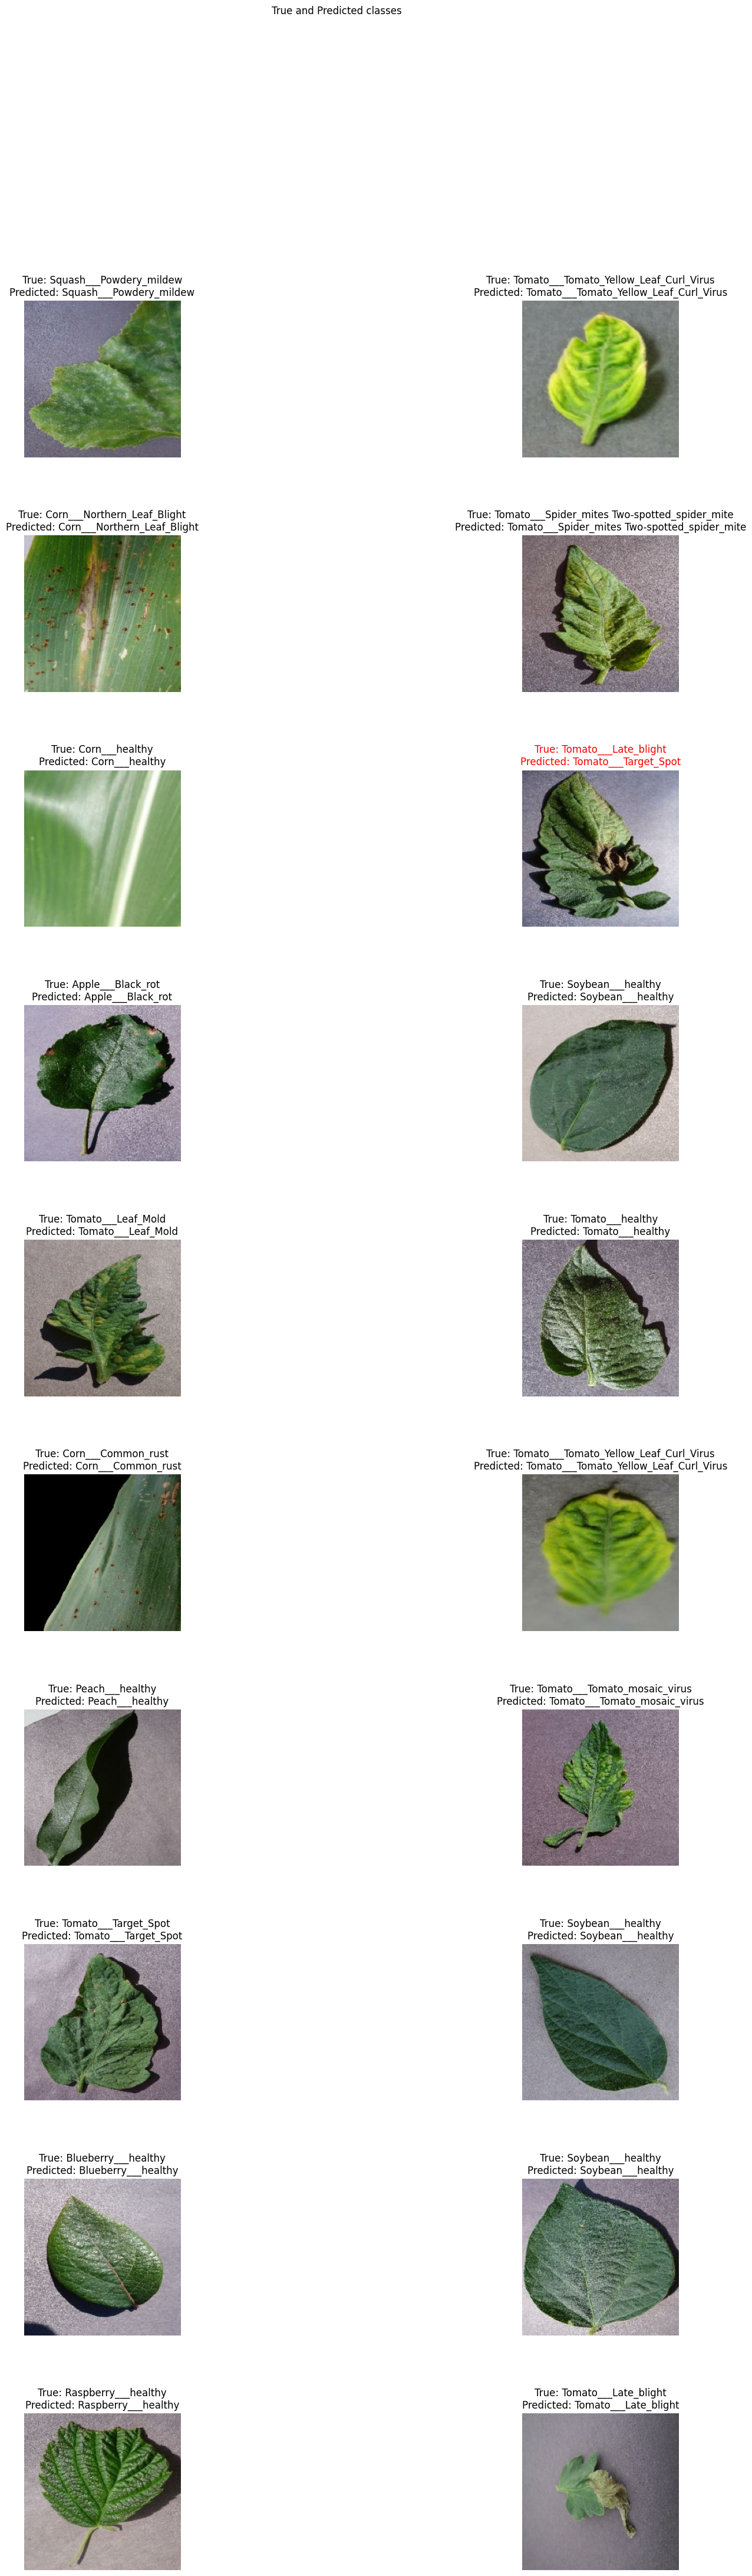

In [24]:
# Make predictions on test set
probabilities = model.predict(ds_test, batch_size=32)
predicted_labels = np.argmax(probabilities, axis=1)

# Display predictions
display_images(test_images, predicted_labels, test_labels, class_names, "True and Predicted classes", num_examples=num_examples)